# UNIT I — Notebook 1: Dataset Understanding + Problem Framing (Stroke Prediction)

## 0) What you will learn

In real ML, the model is the last thing.
First, we must answer:
1. What is the problem exactly?
2. What does each column mean?
3. What type of data do we have (numeric, categorical)?
4. Is the dataset balanced or imbalanced?
5. What could go wrong even before we start?

By the end of this notebook, you should be able to look at any dataset and say:
- "This is a classification/regression problem."
- "These are my features and this is my target."
- "These are the risks (imbalance, leakage, missing values)."
- "These steps are required before training."

No training in this notebook. If someone jumps to training here, they are cheating.


## 1) Problem Framing (Understand it like a story here and when you will work in a company)

Imagine a hospital wants to identify people who have a risk of stroke based on health and lifestyle data.

- If we predict "stroke" correctly early, doctors can intervene.
- If we miss a real stroke case (False Negative), it can be deadly.
- If we incorrectly flag someone as stroke (False Positive), it causes panic + unnecessary tests.

So **the cost of mistakes is not equal**.

That’s why:
- Accuracy is NOT the main goal.
- Recall and Precision will matter later.
- Data imbalance will matter a lot.

Today, we only understand the dataset properly.


## 2) ML Formulation

### 2.1 Task Type
This is a **Supervised Learning** task because we have inputs (features) and a known output (label).

### 2.2 Classification or Regression?
The target column is `stroke`:
- `0` → No stroke
- `1` → Stroke

This is a **Binary Classification** problem.

### 2.3 Input and Output
- Features: age, gender, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, etc.
- Target: stroke


## 3) Setup: Install & Import Libraries

We will use:
- pandas: data handling
- numpy: numeric operations
- matplotlib + seaborn: visualizations

In [2]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# seaborn is useful for quick EDA plots
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# For reproducibility of any random operations later
RANDOM_STATE = 42


## 4) Load the Dataset

### Option A (Kaggle Notebook)
If you attach the dataset in Kaggle, it will appear under `/kaggle/input/...`

### Option B (Local / VS Code)
Use local path like `data/stroke.csv`

We will write code that works in Kaggle and is easy to adapt locally.

In [6]:
# Dataset path (we can edit this if needed)

# Example Kaggle path (you will change folder name based on Kaggle input name)
# path = "/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv"

# Generic placeholder (set correctly once dataset is added)
path = "healthcare-dataset-stroke-data.csv"

df = pd.read_csv(path)
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 5) First Look: Shape, Columns, Data Types

### Why this matters:
- Shape tells you dataset size.
- Columns tell you what information exists.
- dtypes tell you what preprocessing you must do later.

This step prevents stupid mistakes like:
- treating numbers as strings
- treating categories as numbers
- missing the target column


In [5]:
# Basic dataset inspection
print("Shape (rows, cols):", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData types:\n")
df.dtypes


Shape (rows, cols): (5110, 12)

Columns:
 ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Data types:



id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

## 6) Identify Target and Features

We must explicitly separate:
- `y` = target
- `X` = features

This helps avoid leakage and keeps the pipeline clean.


In [7]:
# Target/features split
TARGET_COL = "stroke"

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {df.columns.tolist()}")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nTarget value counts:\n", y.value_counts(dropna=False))


X shape: (5110, 11)
y shape: (5110,)

Target value counts:
 stroke
0    4861
1     249
Name: count, dtype: int64


## 7) Data Dictionary (What Each Column Means)

Students should not treat columns as "just features".
In healthcare, each column is a real-world concept.

Typical columns in this dataset:
- `id`: patient identifier (often should NOT be used for learning)
- `gender`: Male/Female/Other
- `age`: numeric
- `hypertension`: 0/1
- `heart_disease`: 0/1
- `ever_married`: Yes/No
- `work_type`: Private/Self-employed/Govt_job/children/Never_worked
- `Residence_type`: Urban/Rural
- `avg_glucose_level`: numeric
- `bmi`: numeric (often missing)
- `smoking_status`: formerly smoked/never smoked/smokes/Unknown
- `stroke`: 0/1 (target)

Important teaching point:
- `id` is not a medical feature. It’s just an identifier.
- If a model uses `id`, it’s usually memorizing patterns, not learning health risk.


In [8]:
# Quick unique counts to help build "data dictionary intuition"
unique_counts = df.nunique().sort_values(ascending=False)
unique_counts


id                   5110
avg_glucose_level    3979
bmi                   418
age                   104
work_type               5
smoking_status          4
gender                  3
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
dtype: int64

## 8) Check for Missing Values

### Why it matters:
Missing data is guaranteed in real datasets.
If you ignore it, your model will crash or learn garbage.



In [9]:
# Missing values
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_table = pd.DataFrame({
    "missing_count": missing,
    "missing_percent": missing_percent
})

missing_table[missing_table["missing_count"] > 0]


,missing_count,missing_percent
bmi,201,3.93


## 9) Basic Descriptive Statistics (Numeric Features)

### Why it matters:
- Gives the range and scale.
- Helps detect suspicious values.
- Previews whether scaling might be needed.

We will later analyze distributions properly.
Here, we do a quick numeric summary.


In [18]:
# Numeric summary
df.describe(include=[np.number]).T


,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


## 10) Separate Column Types (Numeric vs Categorical)

This is crucial for preprocessing later.

- Numeric columns → scaling, transformations, outliers, imputation strategies
- Categorical columns → encoding, rare category handling, imputation as "Unknown"


In [19]:
# Identify numeric/categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("\nCategorical columns:", categorical_cols)


Numeric columns: ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


## 11) Target Imbalance Check (MOST IMPORTANT EARLY CHECK)

### Why it matters:
If stroke cases are rare (they usually are),
a model can predict "no stroke" always and still get high accuracy.

Example:
If 95% are no-stroke, predicting all 0 gives 95% accuracy.
That model is useless.

So we visualize target distribution now.


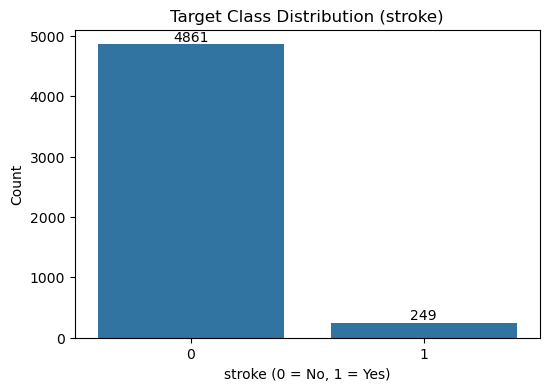

Class distribution (%):
 stroke
0    95.13
1     4.87
Name: proportion, dtype: float64


In [20]:
# Class distribution plot
plt.figure(figsize=(6,4))
ax = sns.countplot(x=y)
plt.title("Target Class Distribution (stroke)")
plt.xlabel("stroke (0 = No, 1 = Yes)")
plt.ylabel("Count")

# Add counts on bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha="center", va="bottom")

plt.show()

# Also show percentage
class_percent = (y.value_counts(normalize=True) * 100).round(2)
print("Class distribution (%):\n", class_percent)


## 12) Quick EDA

In this Notebook we do little exploration:
- Age distribution
- BMI distribution (with missingness awareness)
- Avg glucose distribution
- Stroke rate by hypertension and heart disease

This helps us in seeing:
- which variables might be predictive
- which variables are skewed
- which variables have missing issues


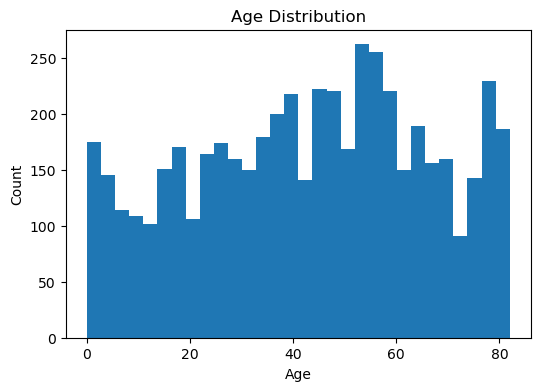

In [24]:
# Age distribution
plt.figure(figsize=(6,4))
plt.hist(df["age"], bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


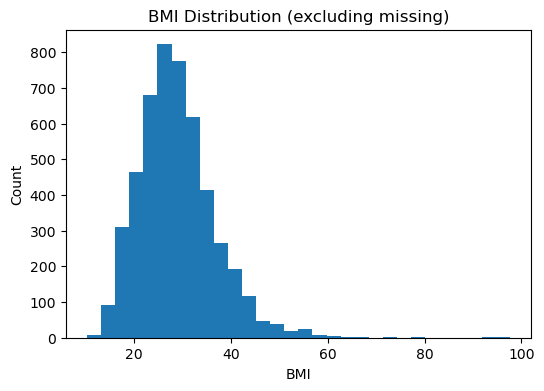

In [25]:
# BMI distribution (note: has missing values)
plt.figure(figsize=(6,4))
plt.hist(df["bmi"].dropna(), bins=30)
plt.title("BMI Distribution (excluding missing)")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()


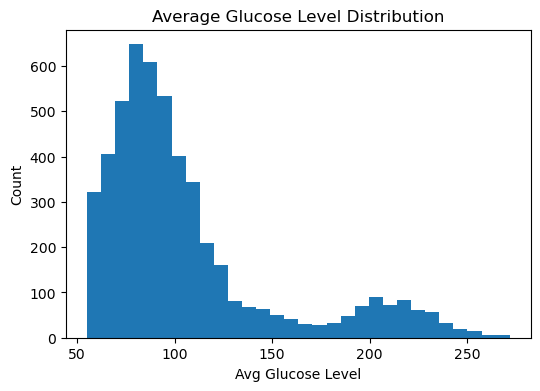

In [26]:
# Avg glucose distribution
plt.figure(figsize=(6,4))
plt.hist(df["avg_glucose_level"], bins=30)
plt.title("Average Glucose Level Distribution")
plt.xlabel("Avg Glucose Level")
plt.ylabel("Count")
plt.show()


In [27]:
# Stroke rate by hypertension and heart disease
def stroke_rate_by(col):
    grp = df.groupby(col)[TARGET_COL].mean().sort_values(ascending=False)
    return (grp * 100).round(2)

print("Stroke rate (%) by hypertension:\n", stroke_rate_by("hypertension"))
print("\nStroke rate (%) by heart_disease:\n", stroke_rate_by("heart_disease"))


Stroke rate (%) by hypertension:
 hypertension
1    13.25
0     3.97
Name: stroke, dtype: float64

Stroke rate (%) by heart_disease:
 heart_disease
1    17.03
0     4.18
Name: stroke, dtype: float64


## 13) Leakage & “Suspicious Columns” (The professional habit)

### What is data leakage?
Leakage happens when a feature contains information that wouldn’t be available at prediction time, or directly reveals the target.

Example:
- A column like "stroke_diagnosis_date" would leak.
- An ID can sometimes leak if it encodes ordering or data source patterns.

In this dataset:
- `id` is not medically meaningful → we will likely drop it later.

We are not dropping now — we’re flagging.


In [28]:
# Check if 'id' exists and inspect basic properties
if "id" in df.columns:
    print("id column detected. Unique values:", df["id"].nunique(), "out of", len(df))
    df["id"].head()
else:
    print("No 'id' column found.")


id column detected. Unique values: 5110 out of 5110


## 14) Notebook 1 Summary (What we learned)

By now we have:
1. Confirmed it is a **binary classification** problem.
2. Identified target and separated X/y.
3. Identified numeric vs categorical columns.
4. Found missing values (e.g., BMI may be missing).
5. Confirmed **class imbalance** exists (usually).
6. Created initial EDA plots to understand distributions.
7. Flagged suspicious columns like `id`.
